In [1]:
import random

import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import CLIPSegForImageSegmentation, CLIPSegProcessor

import amazon_dataset

In [2]:
DATASET = 'Clothing_Shoes_and_Jewelry'

In [3]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [4]:
reviews = amazon_dataset.reviews_df(DATASET)
reviews.sample(n=3)

,id,asin,reviewerID,reviewerName,overall,text,reviewTime,summary,verified,vote
57912,13383217,B00JWW11LO,A1BLLT34RQ9V6R,QualityMindedCheapskate,3.0,"ok material, felt itchy, very narrow slim fit ...",2018-04-19,Three Stars,True,NaN
138923,22867690,B000LNE9Q2,A15KOQE5KMMZ2E,Michael,5.0,"They're expensive, but if they're anything lik...",2018-04-26,but if they're anything like the pants,True,NaN
176731,32053153,B01FVBVVAU,AH9X2C5WCZCCO,Francisco S.,5.0,Love Vintage Silk shirts. Get lots of complime...,2018-07-05,Love it,True,NaN


In [5]:
products = amazon_dataset.products_df(DATASET)
products.sample(n=3)

,asin,description,title,brand,main_cat,rank,price,image_slug,image_url,feature,category,tech_detail
id,,,,,,,,,,,,
2195208,B01674Y3ZU,None,Tailgating Pros Johnson Enterprises Handmade S...,Tailgating Pros,Sports & Outdoors,"159,567inSportsOutdoors(",$19.85,[51mciTAcpVL],[https://m.media-amazon.com/images/I/51mciTAcp...,[HIGH QUALITY Each Set comes with 8 Regulatio...,"[Clothing, Shoes & Jewelry, Men, Clothing, Act...",None
1033439,B00FB6IM30,Shorts in basic ripstop material with matching...,Southpole Men's All-Season Belted Ripstop Basi...,None,None,"10,753inClothing,ShoesJewelry(",$6.44 - $39.95,[61ESg9zV2+L],[https://m.media-amazon.com/images/I/61ESg9zV2...,"[100% Cotton, Imported, Zipper closure, Machin...","[Clothing, Shoes & Jewelry, Men, Surf, Skate &...",None
2212698,B016LPUZLG,GENERAL INFORMATION Upper material: these boo...,Kaitlyn Pan Women's Microsuede Flat Heel Over ...,Kaitlyn Pan,None,"13,819inClothing,ShoesJewelry(",$89.99 - $99.99,[317kugwd17L],[https://images-na.ssl-images-amazon.com/image...,"[Top quality microsuede, The boots with same s...","[Clothing, Shoes & Jewelry, Women, Shoes, Boot...",None


Budweiser Men's Adjustable Straw Baseball Cap with Bottle Opener


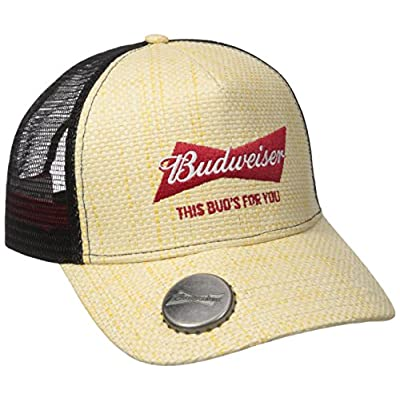

In [230]:
some_product = products.loc[
    ~products['title'].isna() & products['image_slug'].apply(lambda x: len(x) > 0)
].sample(n=1).iloc[0]
some_image_slug = random.choice(some_product['image_slug'])

image_dir = amazon_dataset.product_images_dir(DATASET)
product_image = Image.open(image_dir / f'{some_image_slug}.jpg')

print(some_product['title'])
product_image

In [231]:
prompts = some_product['title'].split(' ') + [ some_product['title'] ]
prompts

['Budweiser',
 "Men's",
 'Adjustable',
 'Straw',
 'Baseball',
 'Cap',
 'with',
 'Bottle',
 'Opener',
 "Budweiser Men's Adjustable Straw Baseball Cap with Bottle Opener"]

In [234]:
prompts = [
 'Budweiser',
 "Men's",
 'Adjustable Straw',
 'Baseball Cap',
 'Bottle Opener',]

In [235]:
inputs = processor(text=prompts, images=[product_image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

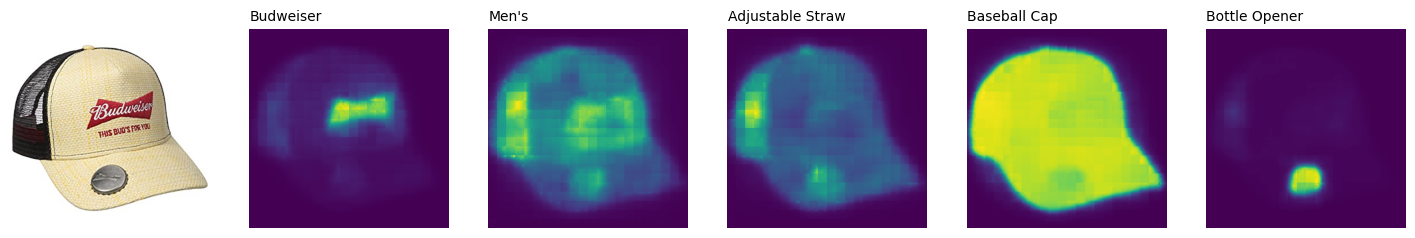

: 

In [236]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))

[a.axis('off') for a in ax.flatten()]

ax[0].imshow(product_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];